In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
import seaborn as sns
import warnings
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import util
from skimage import transform

warnings.filterwarnings('ignore')
det_class_path = 'stage_1_detailed_class_info.csv'
bbox_path = 'stage_1_train_labels.csv'
dicom_dir = 'stage_1_train_images'

In [2]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['lines.linewidth'] = 2.5

28989 class infos loaded
25684 patient cases


,patientId,class
6225,4d476ccd-5814-45a6-85f2-e419c9881065,No Lung Opacity / Not Normal
26012,e8637c78-efa6-4a94-aa10-88f24dfaa44f,No Lung Opacity / Not Normal
22575,cbefe06a-100f-4e77-8fc2-d8af7d0e4cfe,Lung Opacity


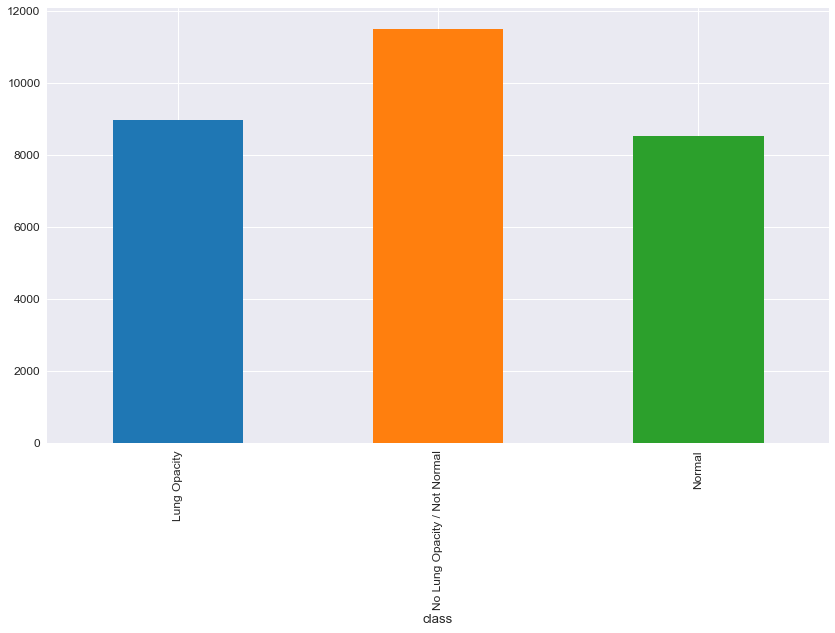

In [3]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

In [4]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

28989 boxes loaded
25684 patient cases


,patientId,x,y,width,height,Target
24308,da6b1618-64b8-41ff-acde-f3058bf7536e,NaN,NaN,NaN,NaN,0
21828,c5dc3440-1fcb-42f5-ad20-aaa163d7b8e0,NaN,NaN,NaN,NaN,0
22530,cb985752-753f-445d-9f97-4e7afc59d906,NaN,NaN,NaN,NaN,0


In [5]:
comb_bbox_df = pd.concat([bbox_df, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

28989 combined cases


,patientId,x,y,width,height,Target,class
25458,e41b9bfd-a369-44f0-bd34-509d71384012,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
21238,c1696635-dfc2-4215-ac85-46825953fc82,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
8421,5f4eb911-ad6e-46da-bc76-2029fcb9dc74,NaN,NaN,NaN,NaN,0,Normal


In [6]:
box_df = comb_bbox_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

,boxes,patients
0,1,22506
1,2,3062
2,3,105
3,4,11


In [7]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,8964
1,No Lung Opacity / Not Normal,0,11500
2,Normal,0,8525


In [8]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

25684 images found


In [9]:
fn=image_df['path']
black_count=np.zeros(25684)
for i in range(0,25684):
    dcm_data=pydicom.read_file(fn[i])
    black_count[i]=np.mean(dcm_data.pixel_array==0)

In [10]:
image_df['mean_black_pixels']=black_count

,BodyPartExamined,ViewPosition,PatientSex
count,25684,25684,25684
unique,1,2,2
top,CHEST,PA,M
freq,25684,13979,14593


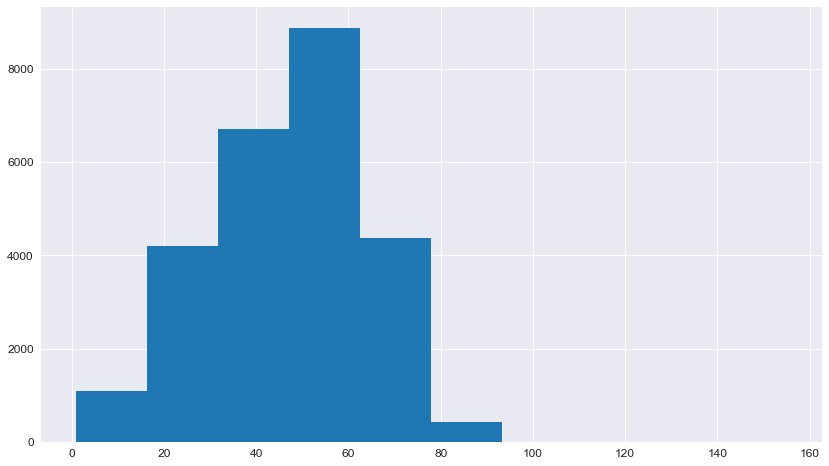

In [11]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [12]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')
image_bbox_df = pd.merge(comb_box_df, 
                         image_full_df, 
                         on='patientId',
                        how='left')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.sample(3)

28989 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path,mean_black_pixels,PatientAge,BodyPartExamined,ViewPosition,PatientSex
14345,8e015c65-17b3-4426-9ed7-a4e78ee7cf57,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_1_train_images\8e015c65-17b3-4426-9ed7-a...,0.001491,62,CHEST,AP,F
28681,fda9946c-adac-4be9-a57d-c1ee75887c3c,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_1_train_images\fda9946c-adac-4be9-a57d-c...,0.095763,60,CHEST,PA,F
25445,e3eda227-7f29-4e7a-80c3-44337ce0b413,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_1_train_images\e3eda227-7f29-4e7a-80c3-4...,0.005300,23,CHEST,AP,F


In [13]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path,mean_black_pixels,PatientAge,BodyPartExamined,ViewPosition,PatientSex
0,62df23c0-1089-4281-9688-036e92189ba1,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_1_train_images\62df23c0-1089-4281-9688-0...,0.001994,64,CHEST,AP,M
1,e72c42ec-602b-4f13-838d-a4f7b0daa6d5,NaN,NaN,NaN,NaN,0,Normal,1,stage_1_train_images\e72c42ec-602b-4f13-838d-a...,0.002724,19,CHEST,AP,M
2,4955984e-afcd-42fc-a3dd-1daa3df12f3e,289.0,551.0,235.0,354.0,1,Lung Opacity,1,stage_1_train_images\4955984e-afcd-42fc-a3dd-1...,0.000837,62,CHEST,AP,F
3,bdb97b05-a8f7-4cdc-852f-f5398582eeb8,177.0,520.0,265.0,208.0,1,Lung Opacity,2,stage_1_train_images\bdb97b05-a8f7-4cdc-852f-f...,0.015469,71,CHEST,PA,M
4,bdb97b05-a8f7-4cdc-852f-f5398582eeb8,668.0,569.0,235.0,254.0,1,Lung Opacity,2,stage_1_train_images\bdb97b05-a8f7-4cdc-852f-f...,0.015469,71,CHEST,PA,M
5,3fdcd01b-1029-40c9-be8a-a72876d0323b,730.0,560.0,104.0,231.0,1,Lung Opacity,3,stage_1_train_images\3fdcd01b-1029-40c9-be8a-a...,0.002028,51,CHEST,AP,F
6,3fdcd01b-1029-40c9-be8a-a72876d0323b,232.0,508.0,206.0,242.0,1,Lung Opacity,3,stage_1_train_images\3fdcd01b-1029-40c9-be8a-a...,0.002028,51,CHEST,AP,F
7,3fdcd01b-1029-40c9-be8a-a72876d0323b,612.0,159.0,125.0,267.0,1,Lung Opacity,3,stage_1_train_images\3fdcd01b-1029-40c9-be8a-a...,0.002028,51,CHEST,AP,F
8,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,342.0,157.0,148.0,113.0,1,Lung Opacity,4,stage_1_train_images\0d5bc737-03de-4bb8-98a1-4...,0.002533,71,CHEST,AP,M
9,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,633.0,128.0,90.0,195.0,1,Lung Opacity,4,stage_1_train_images\0d5bc737-03de-4bb8-98a1-4...,0.002533,71,CHEST,AP,M


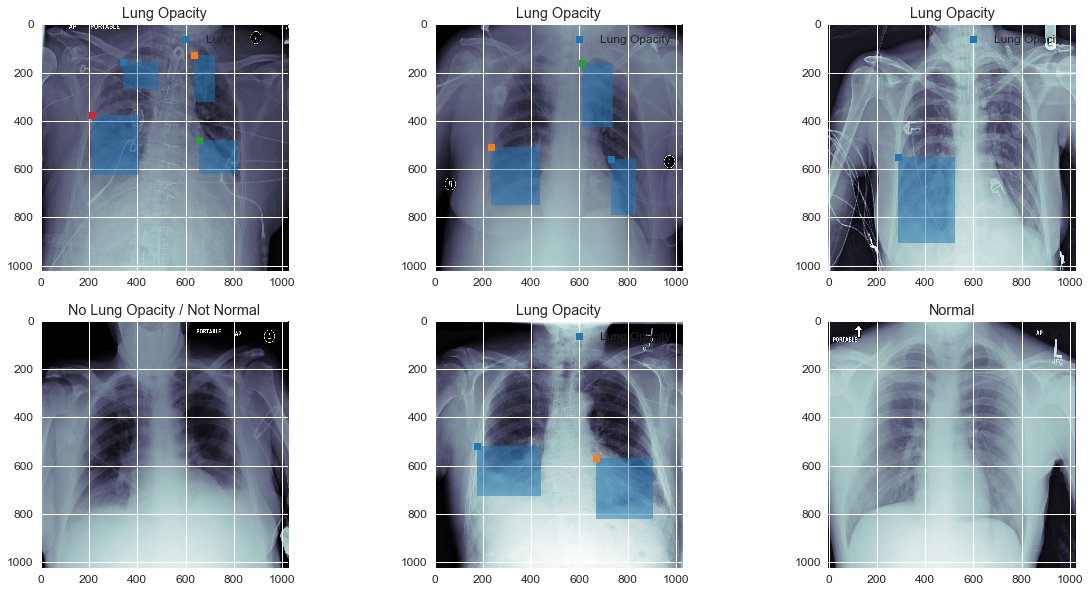

In [14]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

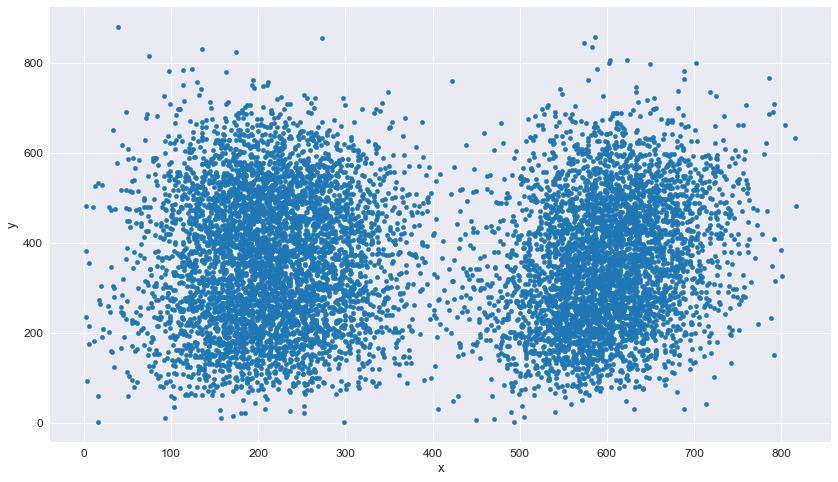

In [15]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

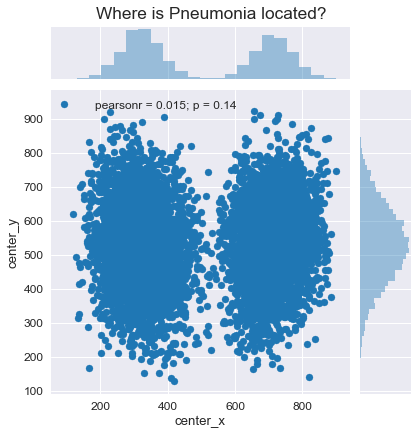

In [16]:
centers = (comb_bbox_df.dropna(subset=['x'])
           .assign(center_x=comb_bbox_df.x + comb_bbox_df.width / 2, center_y=comb_bbox_df.y + comb_bbox_df.height / 2))
ax = sns.jointplot("center_x", "center_y", data=centers)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

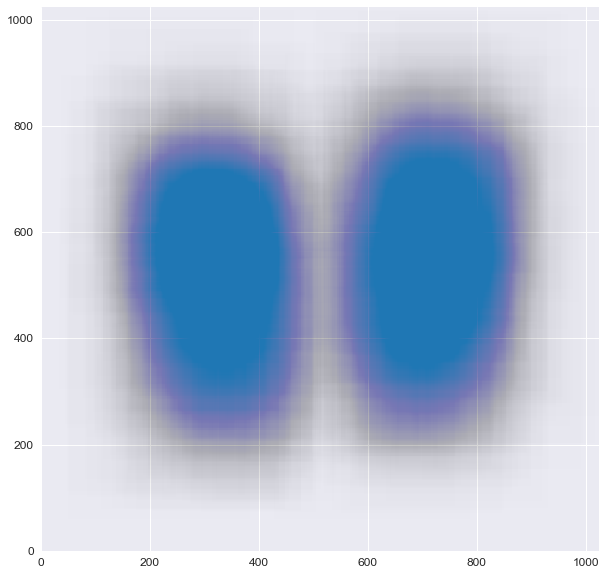

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

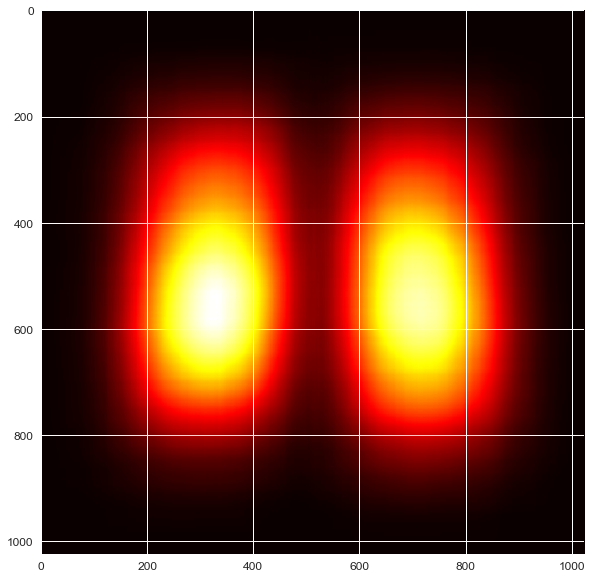

In [18]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

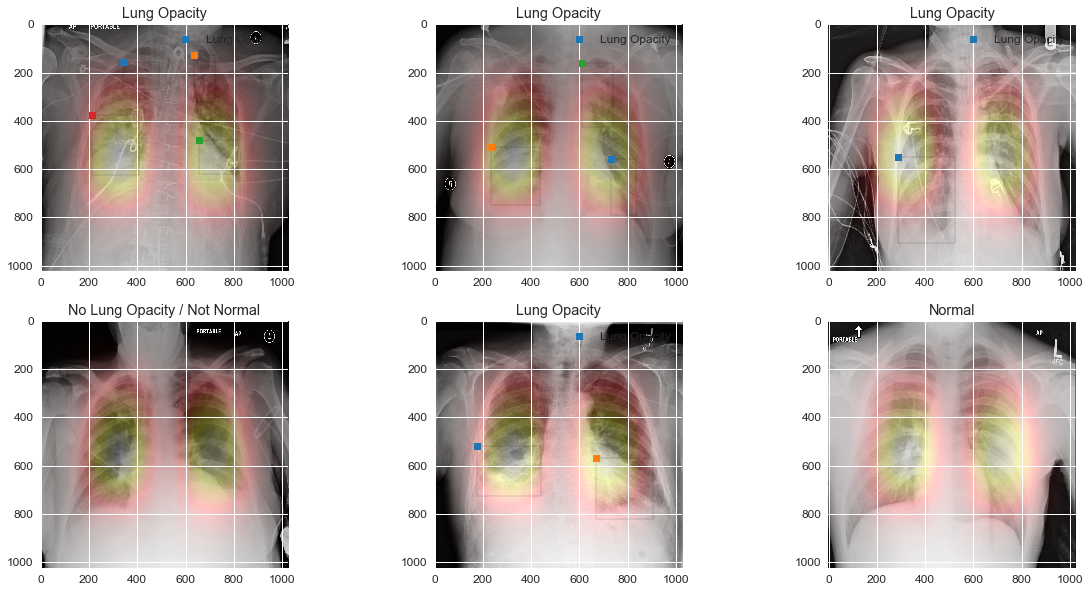

In [19]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)

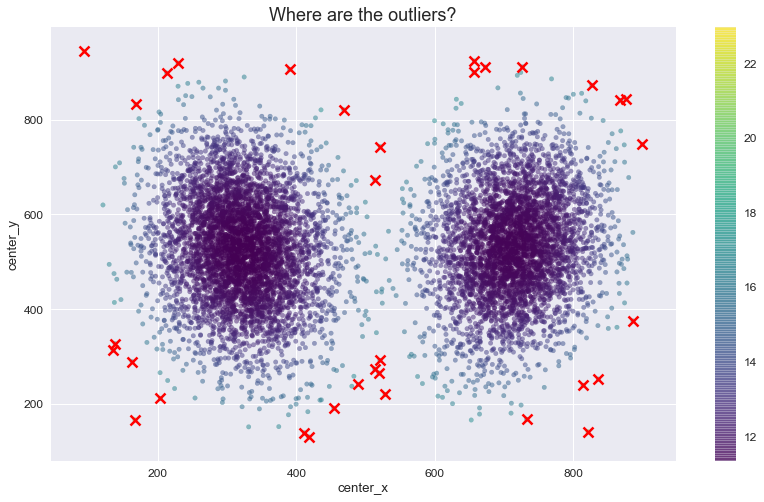

In [20]:
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(n_components=2)
clf.fit(centers[['center_x', 'center_y']])
center_probs = clf.predict_proba(centers[['center_x', 'center_y']])
Z = -clf.score_samples(centers[['center_x', 'center_y']])
outliers = centers.iloc[Z > 17]
fig, ax = plt.subplots()
centers.plot.scatter('center_x', 'center_y', c=Z, alpha=0.5, cmap='viridis', ax=ax)
outliers.plot.scatter('center_x', 'center_y', c='red', marker='x', s=100, ax=ax)
_ = ax.set_title('Where are the outliers?', fontsize=18)

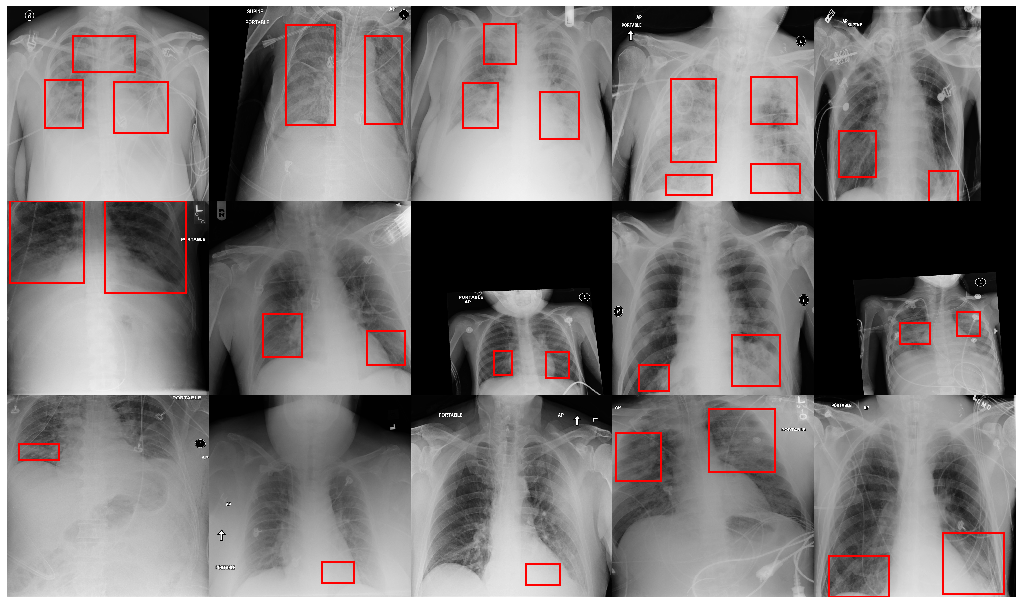

In [21]:
import matplotlib.patches as patches

def get_image(patientId, root_dir='stage_1_train_images'):
    fn = os.path.join(root_dir, f'{patientId}.dcm')
    dcm_data = pydicom.read_file(fn)
    return dcm_data.pixel_array

def draw_bbs(bbs, ax):
    for bb in bbs.itertuples():
        rect = patches.Rectangle(
            (bb.x, bb.y), bb.width, bb.height,
            linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

def draw_image(img, bbs, ax):
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if bbs is not None:
        draw_bbs(bbs, ax)

outliers_15 = outliers.drop_duplicates(subset=['patientId']).iloc[:15]
fig, axes = plt.subplots(3, 5)
for row, ax in zip(outliers_15.itertuples(), axes.flatten()):
    img = get_image(row.patientId)
    bbs = comb_bbox_df.loc[comb_bbox_df.patientId == row.patientId, ['x', 'y', 'width', 'height']]
    draw_image(img, bbs, ax)
fig.tight_layout(pad=-0.5)

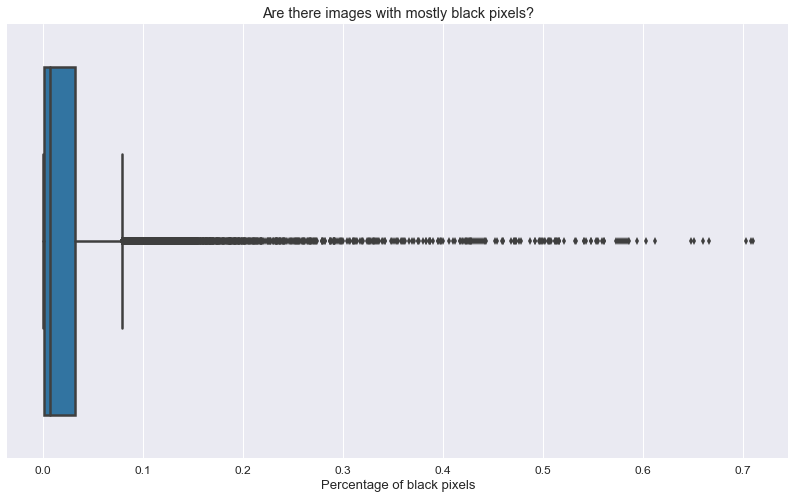

In [22]:
ax = sns.boxplot(image_df.mean_black_pixels)
_ = ax.set_xlabel('Percentage of black pixels')
_ = ax.set_title('Are there images with mostly black pixels?')

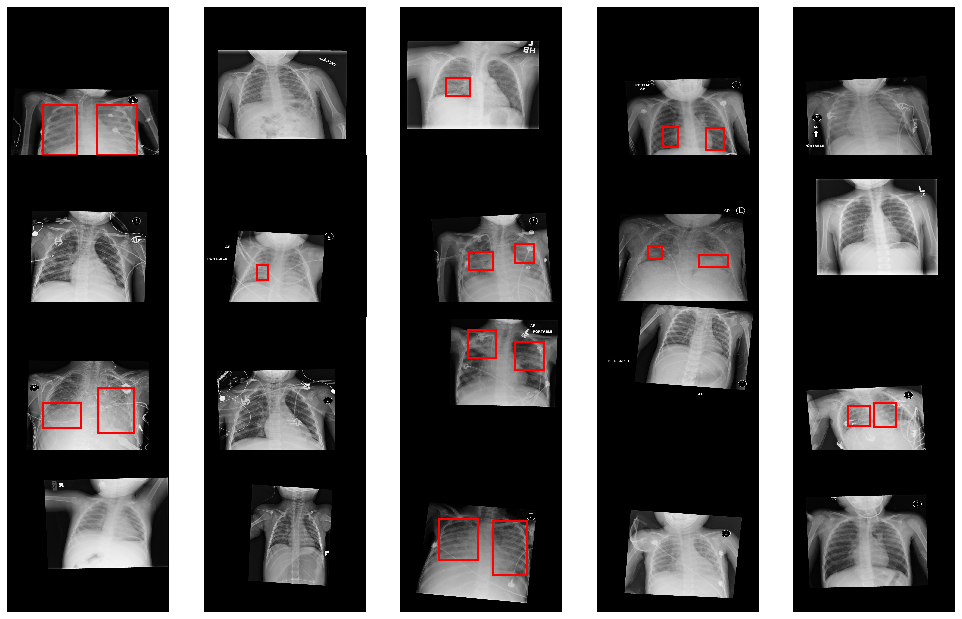

In [23]:
high_black_pixel_patientIds = image_df.loc[image_df.mean_black_pixels > 0.55, 'patientId'].drop_duplicates()
fig, axes = plt.subplots(4, 5)
for i, (patient_id, ax) in enumerate(zip(high_black_pixel_patientIds, axes.flatten())):
    row = image_bbox_df.loc[image_bbox_df.patientId == patient_id]
    img = get_image(row.patientId.iloc[0])
    bbs = row[['x', 'y', 'width', 'height']]
    draw_image(img, bbs, ax)
fig.tight_layout(pad=-1)

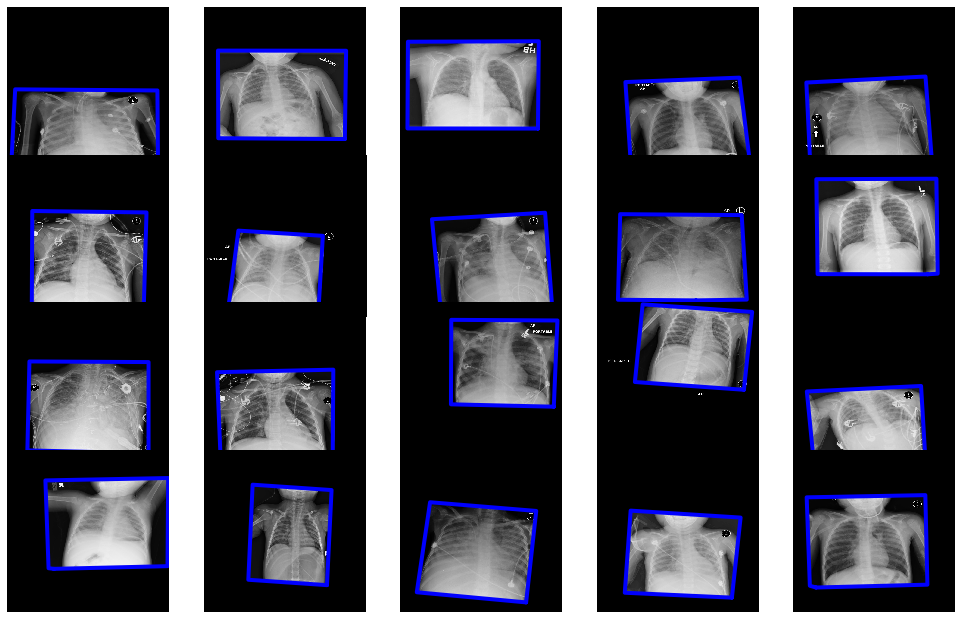

In [24]:
high_black_pixel_images = np.empty(shape=(high_black_pixel_patientIds.shape[0], 1024, 1024))

for i, patient_id in enumerate(high_black_pixel_patientIds):
    row = image_bbox_df.loc[image_bbox_df.patientId == patient_id]
    img = get_image(row.patientId.iloc[0])
    high_black_pixel_images[i] = img 
    
high_black_pixel_contours = []
for img in high_black_pixel_images:
    img2 = feature.canny(img != 0)
    img2 = morphology.convex_hull_image(img2)
    c = measure.find_contours(img2, 0)[0]
    c = measure.approximate_polygon(c, 20)
    high_black_pixel_contours.append(c)

fig, axes = plt.subplots(4, 5)
contours = []
for c, img, ax in zip(high_black_pixel_contours, high_black_pixel_images, axes.flatten()):
    draw_image(img, None, ax)
    _ = ax.plot(c[:, 1], c[:, 0], '-b', linewidth=4)
fig.tight_layout(pad=-1)

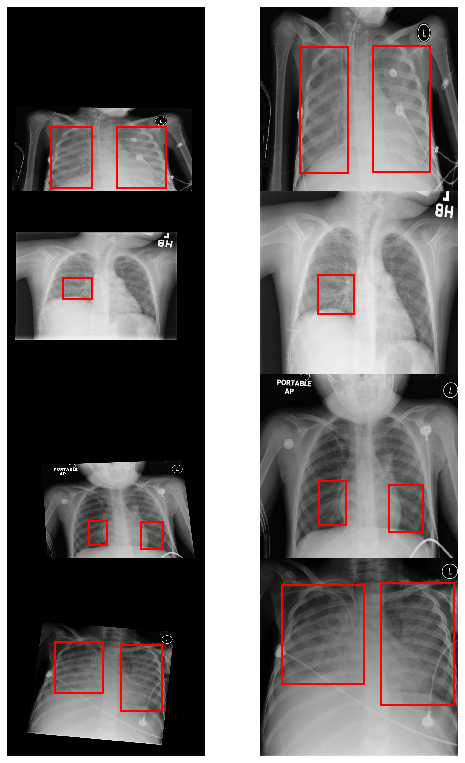

In [25]:
def order_coordinates(coords):
    """Returns coordinates with order:
    (top left, top right, bottom right, bottom left)
    """
    coords = coords[:-1]
    output = np.empty((4, 2), dtype=np.float32)
    dists = coords[:, 1]**2 + coords[:, 0]**2
    ratios = coords[:, 1]/np.sqrt(dists)
    
    tl = coords[np.argmin(dists)]
    br = coords[np.argmax(dists)]
    
    tr = coords[np.argmax(ratios)]
    bl = coords[np.argmin(ratios)]
    
    output[0] = tl
    output[1] = tr
    output[2] = br
    output[3] = bl
    
    return output[:,::-1]

def _convert_bb(bb, tfm):
    x, y, w, h = bb.x, bb.y, bb.width, bb.height
    pts = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ])
    new_pts = tfm.inverse(pts)
    pts_min = np.min(new_pts, axis=0)
    pts_max = np.max(new_pts, axis=0)
    
    x, y = pts_min
    w, h = pts_max - pts_min
    
    return np.array([x, y, w, h])

def convert_bbs(bboxs, tfm):
    output = np.empty_like(bboxs, dtype=np.float32)
    
    for i, bb in enumerate(bboxs.itertuples()):
        output[i] = _convert_bb(bb, tfm)
    
    return pd.DataFrame(output, columns=['x', 'y', 'width', 'height'])

fig, axes = plt.subplots(4, 2, figsize=(8, 10))

orig_coords = np.array([[0, 0], [1024, 0], [1024, 1024], [0, 1024]])
interesting_idices = [0, 2, 3, 17]

for i, (ax1, ax2) in zip(interesting_idices, axes):
    patient_id = high_black_pixel_patientIds.iloc[i]
    img = high_black_pixel_images[i]
    contour = high_black_pixel_contours[i]
    
    row = image_bbox_df.loc[image_bbox_df.patientId == patient_id]
    bbs = row[['x', 'y', 'width', 'height']]
    ordered_coors = order_coordinates(contour)
    tform = transform.estimate_transform('projective', orig_coords, ordered_coors)
    img_t = transform.warp(img, tform, output_shape=(1024, 1024))
    
    new_bbs = convert_bbs(bbs, tform)
    _ = draw_image(img, bbs, ax1)
    _ = draw_image(img_t, new_bbs, ax2)
    
fig.tight_layout(pad=-1)